# Predicting Telco Customer Churn using SparkML on IBM Cloud Pak for Data (ICP4D)

We'll use this notebook to create a machine learning model to predict customer churn. In this notebook we will build the prediction model using the SparkML library.

This notebook walks you through these steps:

- Load and Visualize data set.
- Build a predictive model with SparkML API
- Save the model in the ML repository

* This notebook has been update, in order to compatibilize to the services new versions, and it is part of coe pattern at: https://developer.ibm.com/patterns/data-analysis-model-building-and-deploying-with-wml/

In [1]:

# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
# Generate the TOKEN on settings session, and insert here the code using menu above (3 points) "Insert Project Token"


In [2]:
# The code was removed by Watson Studio for sharing.

## 1.0 Install required packages

There are a couple of Python packages we will use in this notebook. First we make sure the Watson Machine Learning client v3 is removed (its not installed by default) and then install/upgrade the v4 version of the client (this package is installed by default on CP4D).

WML Client: https://wml-api-pyclient-dev-v4.mybluemix.net/#repository

In [3]:
!pip uninstall --yes watson-machine-learning-client-V4
!pip install --user watson-machine-learning-client-V4
!pip install --user pyspark==2.4 --upgrade|tail -n 1
!pip install --user scikit-learn==0.20.3 --upgrade|tail -n 1

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 1.3 MB 15.1 MB/s eta 0:00:01
/opt/conda/envs/Python-3.7-main

In [4]:
import pandas as pd
import numpy as np
import json
import os
import warnings

warnings.filterwarnings("ignore")

## 2.0 Load and Clean data

We'll load our data as a pandas data frame.

**<font color='red'><< FOLLOW THE INSTRUCTIONS BELOW TO LOAD THE DATASET >></font>**

* Highlight the cell below by clicking it.
* Click the `10/01` "Find data" icon in the upper right of the notebook.
* If you are using Virtualized data, begin by choosing the `Files` tab. Then choose your virtualized data (i.e. MYSCHEMA.BILLINGPRODUCTCUSTOMERS), click `Insert to code` and choose `Insert Pandas DataFrame`.
* If you are using this notebook without virtualized data, add the locally uploaded file `Telco-Customer-Churn.csv` by choosing the `Files` tab. Then choose the `Telco-Customer-Churn.csv`. Click `Insert to code` and choose `Insert Pandas DataFrame`.
* The code to bring the data into the notebook environment and create a Pandas DataFrame will be added to the cell below.
* Run the cell


In [5]:
# Place cursor below and insert the Pandas DataFrame for the Telco churn data
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# Insert pandas code below


In [6]:
# The code was removed by Watson Studio for sharing.

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


We'll use the Pandas naming convention df for our DataFrame. Make sure that the cell below uses the name for the dataframe used above. For the locally uploaded file it should look like df_data_1 or df_data_2 or df_data_x. For the virtualized data case it should look like data_df_1 or data_df_2 or data_df_x.

**<font color='red'><< UPDATE THE VARIABLE ASSIGNMENT TO THE VARIABLE GENERATED ABOVE. >></font>**

In [7]:
# for virtualized data
# df = data_df_1

# for local upload
df = df_data_2

### 2.1 Drop CustomerID feature (column)

In [8]:
df = df.drop('customerID', axis=1)

In [9]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 2.2 Examine the data types of the features

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [11]:
# Statistics for the columns (features). Set it to all, since default is to describe just the numeric features.
df.describe(include = 'all')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,6531,2
top,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


We see that Tenure ranges from 0 (new customer) to 6 years, Monthly charges range from $18 to $118, etc

### 2.3 Check for need to Convert TotalCharges column to numeric if it is detected as object

If the above `df.info` shows the "TotalCharges" columnn as an object, we'll need to convert it to numeric. If you have already done this during a previous exercise for "Data Visualization with Data Refinery", you can skip to step `2.4`.

In [12]:
totalCharges = df.columns.get_loc("TotalCharges")
new_col = pd.to_numeric(df.iloc[:, totalCharges], errors='coerce')
df.iloc[:, totalCharges] = pd.Series(new_col)

In [13]:
# Statistics for the columns (features). Set it to all, since default is to describe just the numeric features.
df.describe(include = 'all')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7032.000000,7043
unique,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,NaN,2
top,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,No
freq,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,NaN,5174
mean,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2283.300441,NaN
std,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2266.771362,NaN
min,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000,NaN
25%,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,401.450000,NaN
50%,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1397.475000,NaN
75%,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,3794.737500,NaN


We now see statistics for the `TotalCharges` feature.



### 2.4 Any NaN values should be removed to create a more accurate model.

In [14]:
# Check if we have any NaN values and see which features have missing values that should be addressed
print(df.isnull().values.any())
df.isnull().sum()

True


gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

We should see that the `TotalCharges` column has missing values. There are various ways we can address this issue:

- Drop records with missing values 
- Fill in the missing value with one of the following strategies: Zero, Mean of the values for the column, Random value, etc).

In [15]:
# Handle missing values for nan_column (TotalCharges)
from sklearn.impute import SimpleImputer

# Find the column number for TotalCharges (starting at 0).
total_charges_idx = df.columns.get_loc("TotalCharges")
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

df.iloc[:, total_charges_idx] = imputer.fit_transform(df.iloc[:, total_charges_idx].values.reshape(-1, 1))
df.iloc[:, total_charges_idx] = pd.Series(df.iloc[:, total_charges_idx])

In [16]:
# Validate that we have addressed any NaN values
print(df.isnull().values.any())
df.isnull().sum()

False


gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


### 2.5 Categorize Features

We will categorize some of the columns / features based on wether they are categorical values or continuous (i.e numerical) values. We will use this in later sections to build visualizations.

In [17]:
columns_idx = np.s_[0:] # Slice of first row(header) with all columns.
first_record_idx = np.s_[0] # Index of first record

string_fields = [type(fld) is str for fld in df.iloc[first_record_idx, columns_idx]] # All string fields
all_features = [x for x in df.columns if x != 'Churn']
categorical_columns = list(np.array(df.columns)[columns_idx][string_fields])
categorical_features = [x for x in categorical_columns if x != 'Churn']
continuous_features = [x for x in all_features if x not in categorical_features]

#print('All Features: ', all_features)
#print('\nCategorical Features: ', categorical_features)
#print('\nContinuous Features: ', continuous_features)
#print('\nAll Categorical Columns: ', categorical_columns)

### 2.6 Visualize data

Data visualization can be used to find patterns, detect outliers, understand distribution and more. We can use graphs such as:

- Histograms, boxplots, etc: To find distribution / spread of our continuous variables.
- Bar charts: To show frequency in categorical values.


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

%matplotlib inline
sns.set(style="darkgrid")
sns.set_palette("hls", 3)

First, we get a high level view of the distribution of `Churn`. What percentage of customer in our dataset are churning vs not churning. 

Churn
No     5174
Yes    1869
dtype: int64


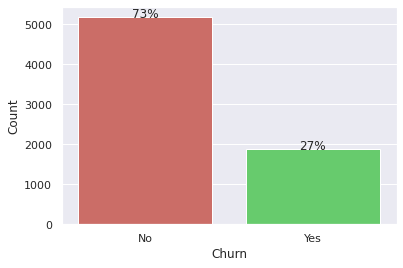

In [19]:
print(df.groupby(['Churn']).size())
churn_plot = sns.countplot(data=df, x='Churn', order=df.Churn.value_counts().index)
plt.ylabel('Count')
for p in churn_plot.patches:
    height = p.get_height()
    churn_plot.text(p.get_x()+p.get_width()/2., height + 1,'{0:.0%}'.format(height/float(len(df))),ha="center") 
plt.show()

We can get use frequency counts charts to get an understanding of the categorical features relative to `Churn`  

- We can see that for the `gender` feature. We have relatively equal rates of churn by `gender`
- We can see that for the `InternetService` feature. We have higher churn for those that have "Fiber optic" service versus those with "DSL"


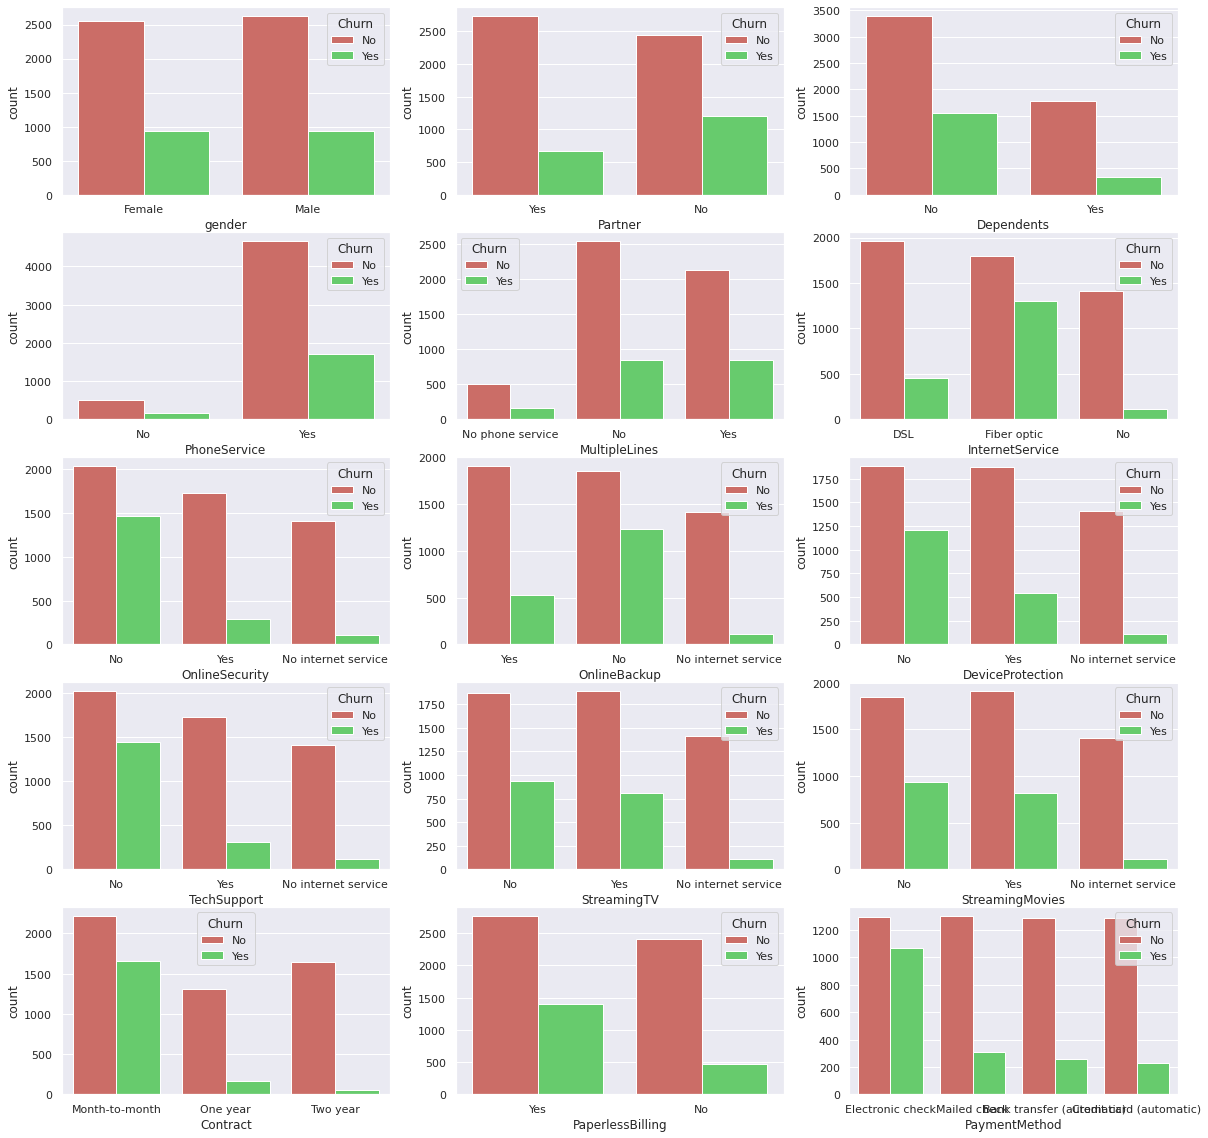

In [20]:
# Categorical feature count plots
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), (ax13, ax14, ax15)) = plt.subplots(5, 3, figsize=(20, 20))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15 ]

for i in range(len(categorical_features)):
    sns.countplot(x = categorical_features[i], hue="Churn", data=df, ax=ax[i])

We can get use histrogram charts to get an understanding of the distribution of our continuous / numerical features relative to Churn.

- We can see that for the `MonthlyCharges` feature, customers that churn tend to pay higher monthly fees than those that stay.
- We can see that for the `tenure` feature, customers that churn tend to be relatively new customers.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd19a3e2b50>,
      dtype=object)

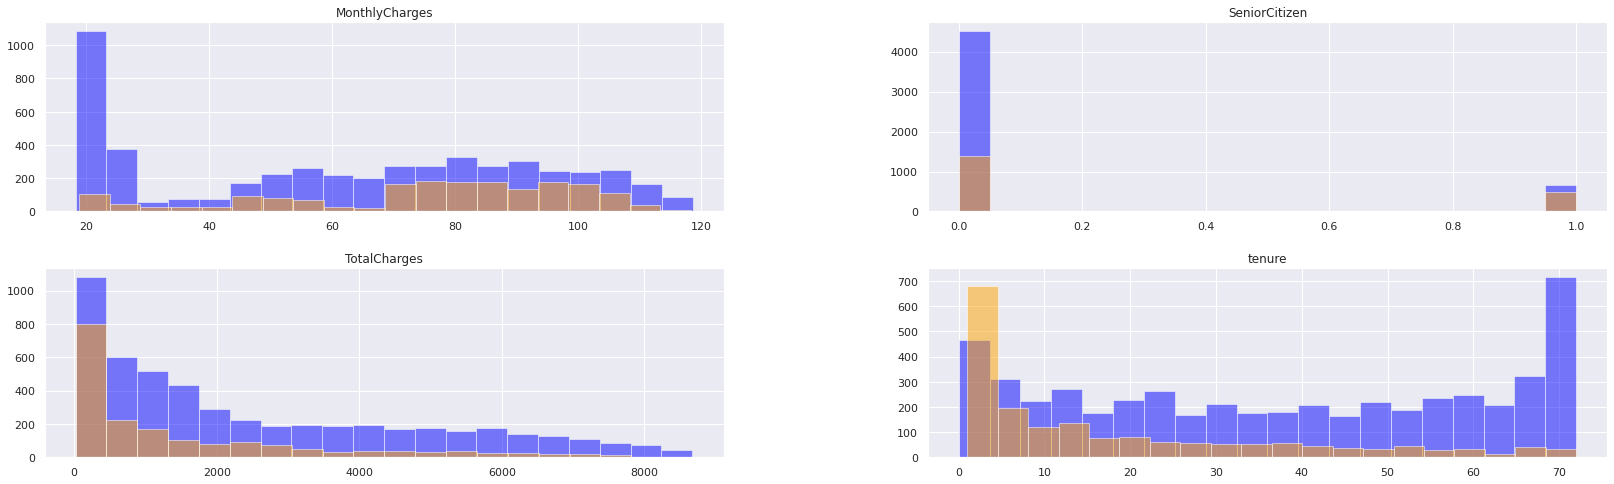

In [21]:
# Continuous feature histograms.
fig, ax = plt.subplots(2, 2, figsize=(28, 8))
df[df.Churn == 'No'][continuous_features].hist(bins=20, color="blue", alpha=0.5, ax=ax)
df[df.Churn == 'Yes'][continuous_features].hist(bins=20, color="orange", alpha=0.5, ax=ax)

# Or use displots
#sns.set_palette("hls", 3)
#f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 25))
#ax = [ax1, ax2, ax3, ax4]
#for i in range(len(continuous_features)):
#    sns.distplot(df[continuous_features[i]], bins=20, hist=True, ax=ax[i])

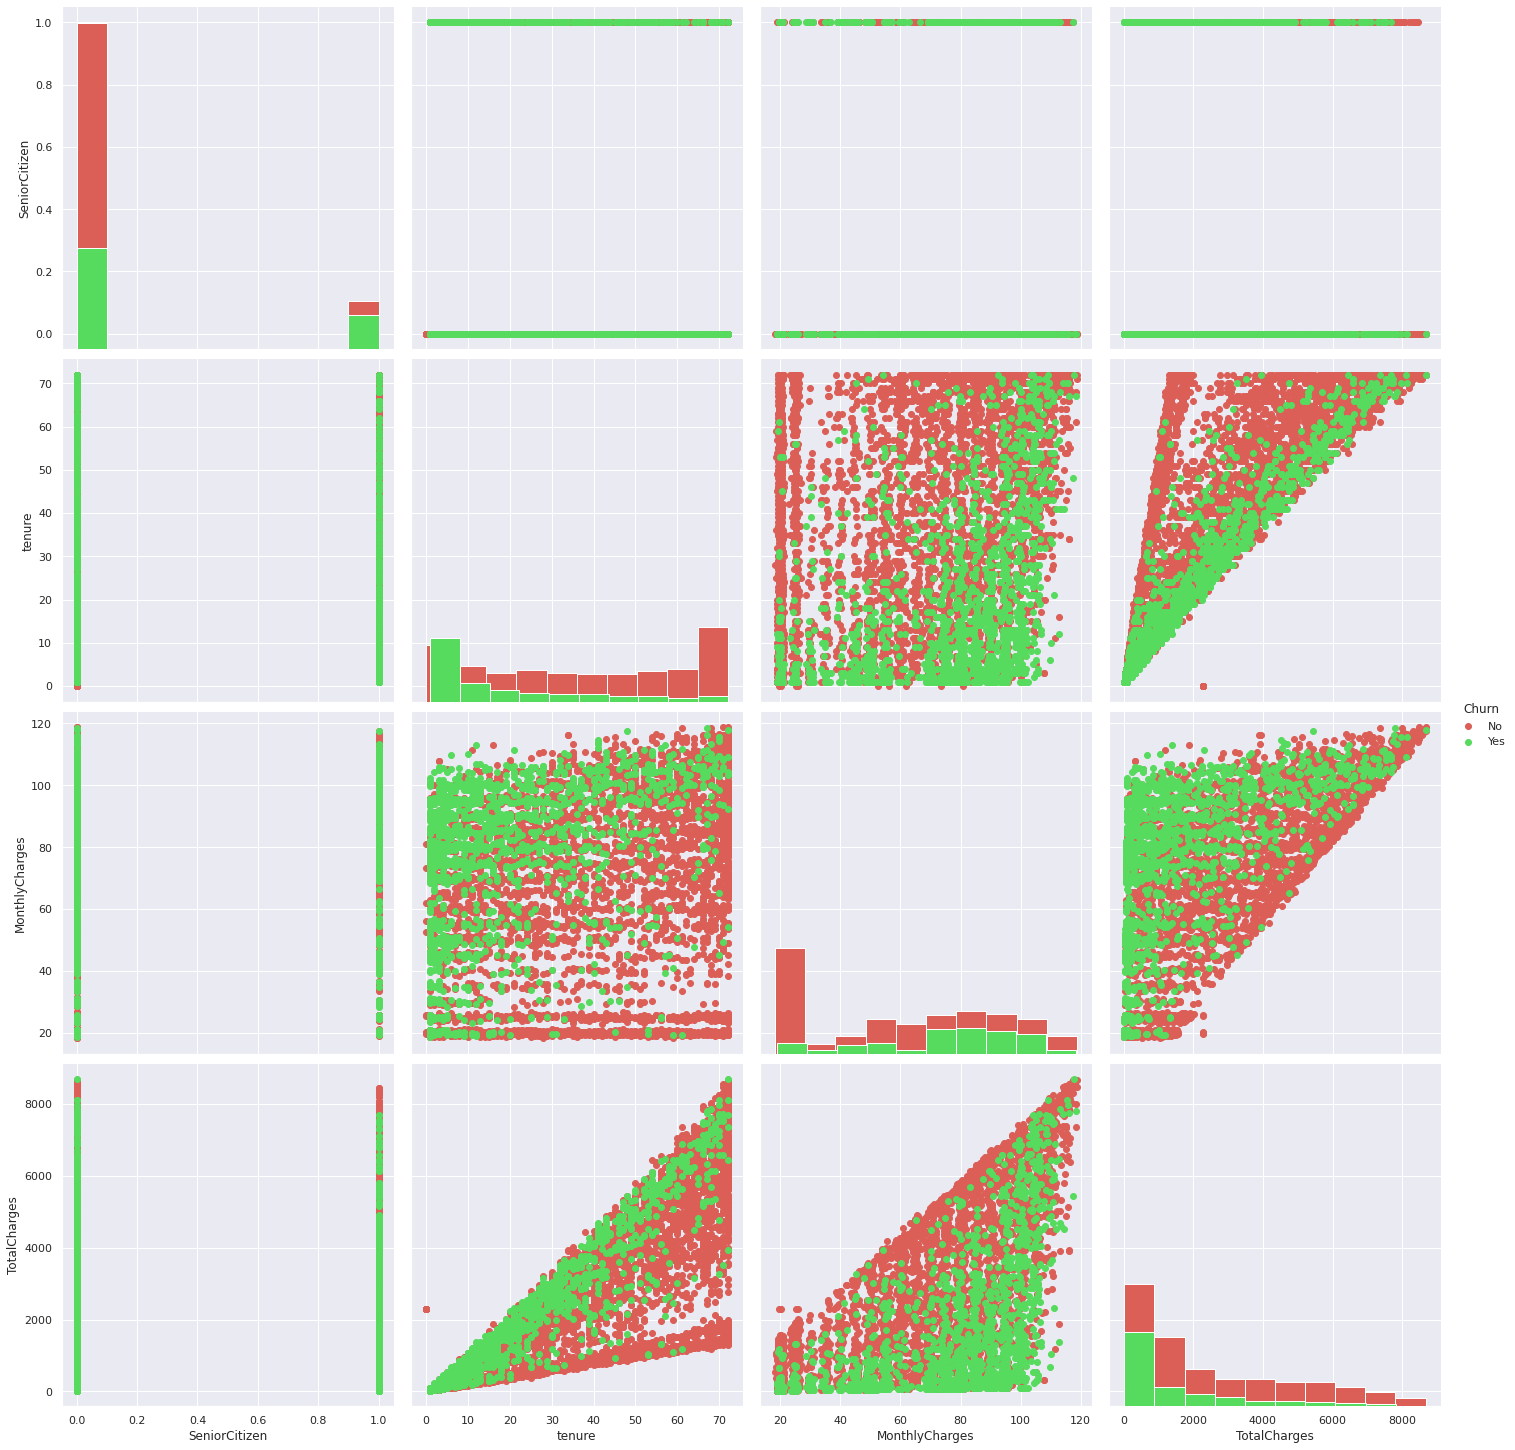

In [22]:
# Create Grid for pairwise relationships
gr = sns.PairGrid(df, height=5, hue="Churn")
gr = gr.map_diag(plt.hist)
gr = gr.map_offdiag(plt.scatter)
gr = gr.add_legend()

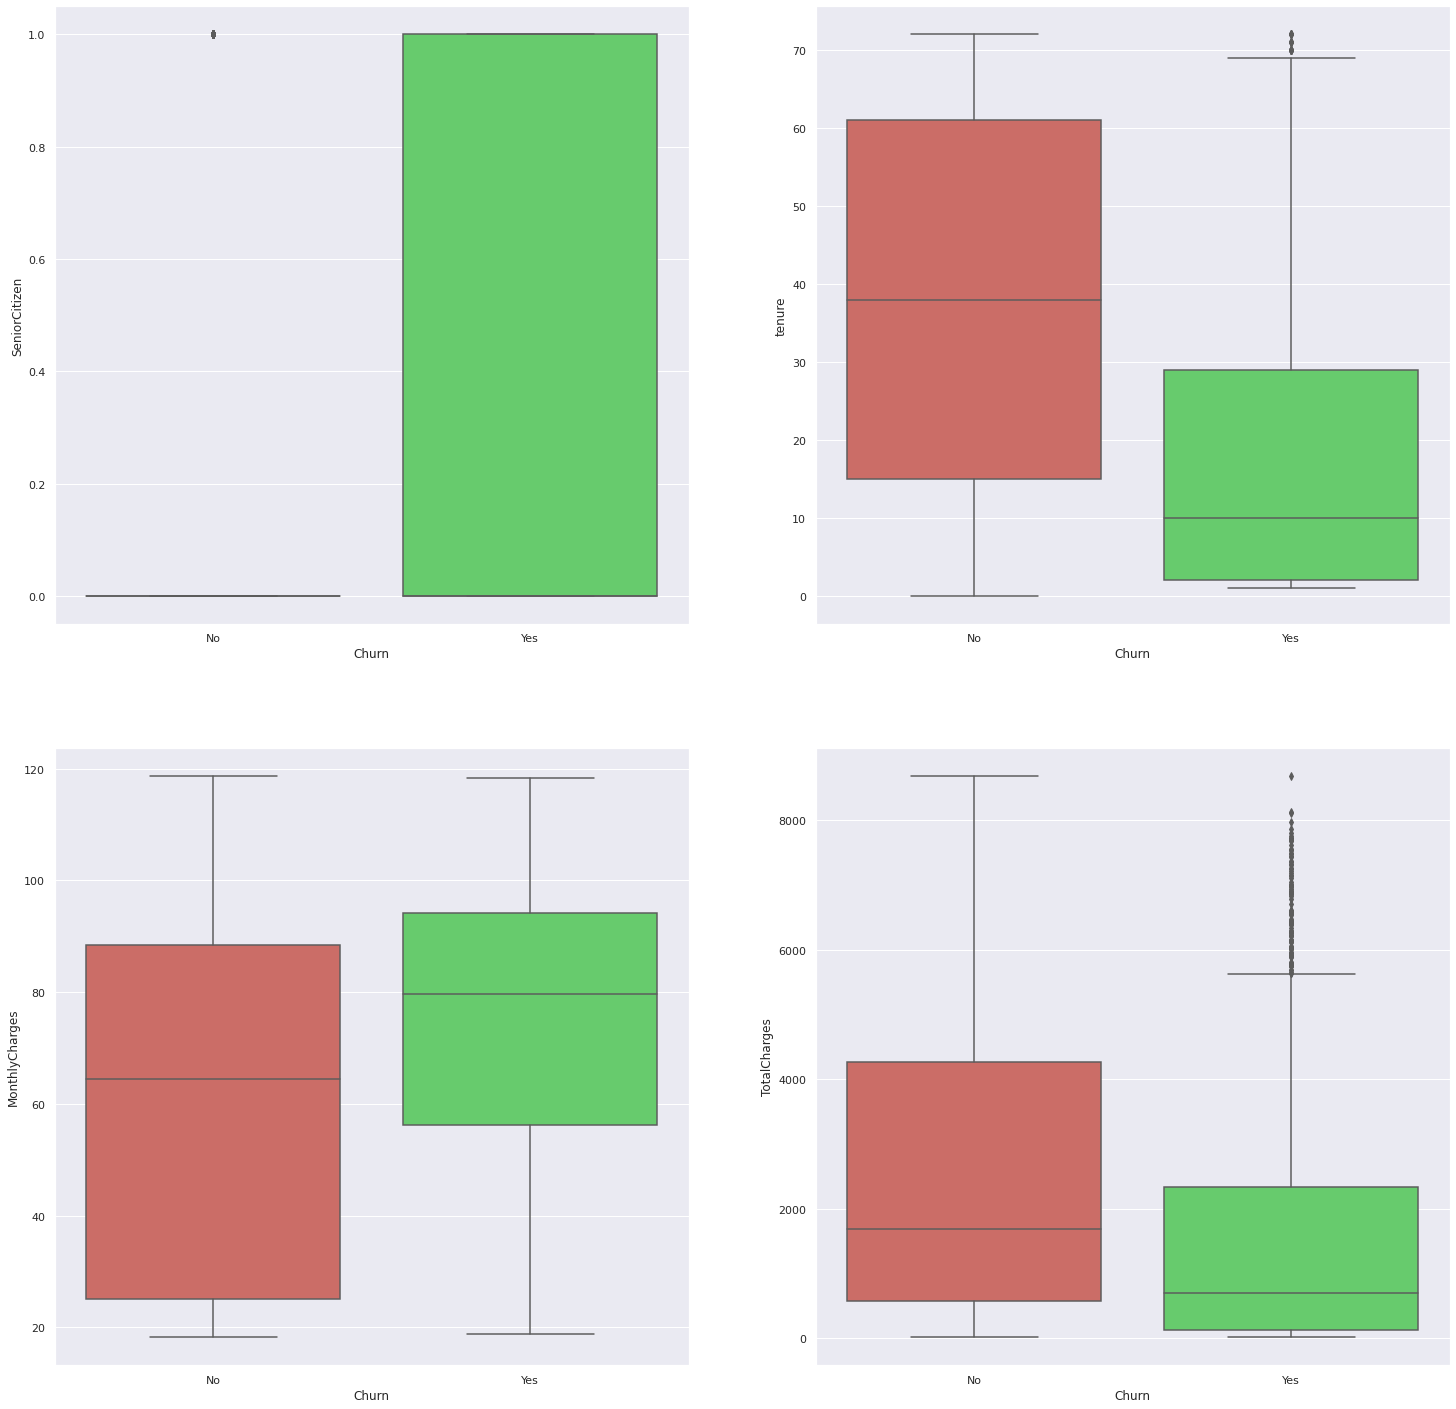

In [23]:
# Plot boxplots of numerical columns. More variation in the boxplot implies higher significance. 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 25))
ax = [ax1, ax2, ax3, ax4]

for i in range(len(continuous_features)):
    sns.boxplot(x = 'Churn', y = continuous_features[i], data=df, ax=ax[i])

## 3.0 Create a model

Now we can create our machine learning model. You could use the insights / intuition gained from the data visualization steps above to what kind of model to create or which features to use. We will create a simple classification model.

In [24]:
from pyspark.sql import SparkSession
import pandas as pd
import json

spark = SparkSession.builder.getOrCreate()
df_data = spark.createDataFrame(df)
df_data.head()

Row(gender='Female', SeniorCitizen=0, Partner='Yes', Dependents='No', tenure=1, PhoneService='No', MultipleLines='No phone service', InternetService='DSL', OnlineSecurity='No', OnlineBackup='Yes', DeviceProtection='No', TechSupport='No', StreamingTV='No', StreamingMovies='No', Contract='Month-to-month', PaperlessBilling='Yes', PaymentMethod='Electronic check', MonthlyCharges=29.85, TotalCharges=29.85, Churn='No')

### 3.1 Split the data into training and test sets

In [25]:
spark_df = df_data
(train_data, test_data) = spark_df.randomSplit([0.8, 0.2], 24)

print("Number of records for training: " + str(train_data.count()))
print("Number of records for evaluation: " + str(test_data.count()))

Number of records for training: 5662
Number of records for evaluation: 1381


### 3.2 Examine the Spark DataFrame Schema
Look at the data types to determine requirements for feature engineering

In [26]:
spark_df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: long (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: long (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



### 3.3 Use StringIndexer to encode a string column of labels to a column of label indices

We are using the Pipeline package to build the development steps as pipeline. 
We are using StringIndexer to handle categorical / string features from the dataset. StringIndexer encodes a string column of labels to a column of label indices

We then use VectorAssembler to asemble these features into a vector. Pipelines API requires that input variables are passed in  a vector

In [27]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model


si_gender = StringIndexer(inputCol = 'gender', outputCol = 'gender_IX')
si_Partner = StringIndexer(inputCol = 'Partner', outputCol = 'Partner_IX')
si_Dependents = StringIndexer(inputCol = 'Dependents', outputCol = 'Dependents_IX')
si_PhoneService = StringIndexer(inputCol = 'PhoneService', outputCol = 'PhoneService_IX')
si_MultipleLines = StringIndexer(inputCol = 'MultipleLines', outputCol = 'MultipleLines_IX')
si_InternetService = StringIndexer(inputCol = 'InternetService', outputCol = 'InternetService_IX')
si_OnlineSecurity = StringIndexer(inputCol = 'OnlineSecurity', outputCol = 'OnlineSecurity_IX')
si_OnlineBackup = StringIndexer(inputCol = 'OnlineBackup', outputCol = 'OnlineBackup_IX')
si_DeviceProtection = StringIndexer(inputCol = 'DeviceProtection', outputCol = 'DeviceProtection_IX')
si_TechSupport = StringIndexer(inputCol = 'TechSupport', outputCol = 'TechSupport_IX')
si_StreamingTV = StringIndexer(inputCol = 'StreamingTV', outputCol = 'StreamingTV_IX')
si_StreamingMovies = StringIndexer(inputCol = 'StreamingMovies', outputCol = 'StreamingMovies_IX')
si_Contract = StringIndexer(inputCol = 'Contract', outputCol = 'Contract_IX')
si_PaperlessBilling = StringIndexer(inputCol = 'PaperlessBilling', outputCol = 'PaperlessBilling_IX')
si_PaymentMethod = StringIndexer(inputCol = 'PaymentMethod', outputCol = 'PaymentMethod_IX')


In [28]:
si_Label = StringIndexer(inputCol="Churn", outputCol="label").fit(spark_df)
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=si_Label.labels)

### 3.4 Create a single vector

In [29]:
va_features = VectorAssembler(inputCols=['gender_IX',  'SeniorCitizen', 'Partner_IX', 'Dependents_IX', 'PhoneService_IX', 'MultipleLines_IX', 'InternetService_IX', \
                                         'OnlineSecurity_IX', 'OnlineBackup_IX', 'DeviceProtection_IX', 'TechSupport_IX', 'StreamingTV_IX', 'StreamingMovies_IX', \
                                         'Contract_IX', 'PaperlessBilling_IX', 'PaymentMethod_IX', 'TotalCharges', 'MonthlyCharges'], outputCol="features")

### 3.5 Create a pipeline, and fit a model using RandomForestClassifier 
Assemble all the stages into a pipeline. We don't expect a clean linear regression, so we'll use RandomForestClassifier to find the best decision tree for the data.

In [30]:
classifier = RandomForestClassifier(featuresCol="features")

pipeline = Pipeline(stages=[si_gender, si_Partner, si_Dependents, si_PhoneService, si_MultipleLines, si_InternetService, si_OnlineSecurity, si_OnlineBackup, si_DeviceProtection, \
                            si_TechSupport, si_StreamingTV, si_StreamingMovies, si_Contract, si_PaperlessBilling, si_PaymentMethod, si_Label, va_features, \
                            classifier, label_converter])

model = pipeline.fit(train_data)

In [31]:
predictions = model.transform(test_data)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction")
area_under_curve = evaluatorDT.evaluate(predictions)

evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction",  metricName='areaUnderROC')
area_under_curve = evaluatorDT.evaluate(predictions)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction",  metricName='areaUnderPR')
area_under_PR = evaluatorDT.evaluate(predictions)
print("areaUnderROC = %g" % area_under_curve)

areaUnderROC = 0.704097


## 4.0 Save the model and test data

Now the model can be saved for future deployment. The model will be saved using the Watson Machine Learning client, to a deployment space.

**<font color='red'><< UPDATE THE VARIABLE 'MODEL_NAME' TO A UNIQUE NAME>></font>**

**<font color='red'><< UPDATE THE VARIABLE 'DEPLOYMENT_SPACE_NAME' TO THE NAME OF THE DEPLOYMENT SPACE CREATED PREVIOUSLY>></font>**

In [ ]:

MODEL_NAME = "GAMA-PREDICT-CHURN"
DEPLOYMENT_SPACE_NAME = 'Big-Data'


### 4.1 Save the model to ICP4D local Watson Machine Learning

1. Generate an API Key: https://cloud.ibm.com/iam/apikeys
2. Generate a TOKEN for your Watson Machine Learning:
   curl --insecure -X POST --header "Content-Type: application/x-www-form-urlencoded" --header "Accept: application/json" --data-urlencode "grant_type=urn:ibm:params:oauth:grant-type:apikey" --data-urlencode "apikey=$API_key" "https://iam.ng.bluemix.net/identity/token"
3.   <font color='red'>Replace the `token` value of `*****` with `token` generate. The value for `url` should match the `url` for your Watson Machine Learning.</font>

In [ ]:
from ibm_watson_machine_learning import APIClient

wml_credentials = {
                   "url": "https://us-south.ml.cloud.ibm.com",
                   "token":"*******"
}


In [ ]:
# The code was removed by Watson Studio for sharing.

In [ ]:
client.spaces.list()

### Use the desired space as the `default_space`

The deployment space ID will be looked up based on the name specified above. If you do not receive a space GUID as an output to the next cell, do not proceed until you have created a deployment space.

In [ ]:
# Be sure to update the name of the space with the one you want to use.
#client.spaces.list()
all_spaces = client.spaces.get_details()['resources']
space_id = None
#print(all_spaces)
for space in all_spaces:
    if space['entity']['name'] == DEPLOYMENT_SPACE_NAME:
        space_id = space["metadata"]["id"]
        print("\nDeployment Space GUID: ", space_id)

if space_id is None:
    print("WARNING: Your space does not exist. Create a deployment space before proceeding to the next cell.")
    #space_id = client.spaces.store(meta_props={client.spaces.ConfigurationMetaNames.NAME: space_name})["metadata"]["guid"]

**<font color='red'><< REPLACE space_id BELOW with the id for your space. For e.g.<br/>client.set.default_space("6b39c537-f707-4078-9dc7-ce70b70ab22f") >></font>**

In [ ]:
# Now set the default space to the GUID for your deployment space. If this is successful, you will see a 'SUCCESS' message.
client.set.default_space(space_id)

#### Save the Model

In [ ]:
# case you need check the services, uncomment th eline below and run it.
#client.software_specifications.list()

In [ ]:
software_spec_id =  client.software_specifications.get_id_by_name('spark-mllib_2.4')
print(software_spec_id)

In [ ]:
# Store our model
model_props = {client.repository.ModelMetaNames.NAME: MODEL_NAME,
               client.repository.ModelMetaNames.SOFTWARE_SPEC_UID : software_spec_id,
               client.repository.ModelMetaNames.TYPE : "mllib_2.4"}
published_model = client.repository.store_model(model=model, pipeline=pipeline, meta_props=model_props, training_data=train_data)

print(json.dumps(published_model, indent=3))

In [ ]:
# Use this cell to do any cleanup of previously created models and deployments
client.repository.list_models()
client.deployments.list()

# client.repository.delete('GUID of stored model')
# client.deployments.delete('GUID of deployed model')


## 5.0 Save Test Data

We will save the test data we used to evaluate the model to our project.

In [ ]:
write_score_CSV=test_data.toPandas().drop(['Churn'], axis=1)
#write_score_CSV.to_csv('/project_data/data_asset/TelcoCustomerSparkMLBatchScore.csv', sep=',', index=False)
project.save_data('TelcoCustomerSparkMLBatchScore.csv', write_score_CSV.to_csv(), overwrite=True)

write_eval_CSV=test_data.toPandas()
#write_eval_CSV.to_csv('/project_data/data_asset/TelcoCustomerSparkMLEval.csv', sep=',', index=False)
project.save_data('TelcoCustomerSparkMLEval.csv', write_eval_CSV.to_csv(), overwrite=True)

## Congratulations, you have created a model based on customer churn data, and deployed it to Watson Machine Learning!